# Wine Quality Prediction



In this project, I work on [Wine Quality Data Set](https://archive.ics.uci.edu/ml/datasets/Wine+Quality) from UCI Machine Learning Repository. This notebook consists of my approach for finding the best way to predict the Wine Quality with this dataset.

For this project, I've taken inspiration from work of people on [Wine Quality Kaggle Dataset](https://www.kaggle.com/rajyellow46/wine-quality/code). Please note that the dataset on Kaggle is slightly different from UCI Respository. I hope anyone looking at this finds some value out of my work. :)
<br>

Citation:<br>
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties.
In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.

<br>

### Overview of Project

- __Preparing Data:__ We read the dataset, add column for wine type, and scale it.
- __EDA:__ We do basic checks for null values, check details of all attributes, and do basic visualisations to get insights from the dataset.
- __Solving Class Imbalance:__ We try to solve Class Imabalance issue in dataset using class weights, oversampling, and aggregation of classes.
- __Spot-Checking Algorithms:__ We check which algorithm would be best for our dataset by doing cross validation with various algorithms for classification. For this, we use a [Spot-Check framework](https://machinelearningmastery.com/spot-check-machine-learning-algorithms-in-python/).
- __Hyperparameter Tuning:__ From the results of Spot-Checking, we pick three best. Also comparing them with Deep Learning model and go ahead with best performing model. We do hyperparameter tuning for best model and analyse results.
- __Conclusion:__ We conclude which model(s) would be useful and why. Also mentioning further work to be done.

<br>
<br>
Let's start by importing required libraries.

In [85]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

## Preparing Data

<br>
We'll read both the files that have data of red and white wine then combine them into one dataframe later.

In [86]:
redwine = pd.read_csv('winequality-red.csv',delimiter=';')
whitewine = pd.read_csv('winequality-white.csv',delimiter=';')

Adding a new 'type' column in each dataset to denote if the wine is white or red. Then we concatenate data from the two files and print shapes to make sure concatenation is successful.

In [87]:
redwine['type'] = 0
whitewine['type'] = 1

df = pd.concat([redwine,whitewine])

print(redwine.shape)
print(whitewine.shape)
print(df.shape)

(1599, 13)
(4898, 13)
(6497, 13)


Shuffling the dataframe rows to randomize the sequence of examples.

In [88]:
df = df.sample(frac=1).reset_index(drop=True)

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.32,0.27,1.4,0.049,38.0,173.0,0.99335,3.03,0.52,9.3,5,1
1,7.4,0.22,0.26,1.2,0.035,18.0,97.0,0.99245,3.12,0.41,9.7,6,1
2,10.8,0.47,0.43,2.1,0.171,27.0,66.0,0.99820,3.17,0.76,10.8,6,0
3,6.2,0.29,0.32,3.6,0.026,39.0,138.0,0.98920,3.31,0.37,13.1,7,1
4,8.8,0.19,0.30,5.0,0.028,34.0,120.0,0.99242,2.94,0.47,11.2,5,1


<br>

Splitting the dataset into train and test. We use stratify argument for our class label column. This ensures that number of examples from every class is in the same proportion as train and test split.

In [89]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('quality',axis=1), df['quality'],test_size=0.3,
                                                   stratify=df['quality'])

print("Train test split:")
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print()

print("Y train value counts:")
print(y_train.value_counts())

Train test split:
(4547, 12)
(4547,)
(1950, 12)
(1950,)

Y train value counts:
6    1985
5    1496
7     755
4     151
8     135
3      21
9       4
Name: quality, dtype: int64


<br>
We'll also scale the features usign MinMaxScaler. Notice that we're not scaling the type column since it has binary value and doesn't need scaling.

In [90]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

features = list(X_train.columns)
features.remove('type')

ct_mms = ColumnTransformer([('MinMaxScaler', MinMaxScaler(), features)], remainder='passthrough')
Xt_mms = ct_mms.fit_transform(X_train)
Xts_mms = ct_mms.transform(X_test)

## EDA

Start by checking for null values and short summary about dataset.

In [91]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
dtype: int64

In [92]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.753886
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,1.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,1.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000


In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type                  6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 660.0 KB


We have no null values and all the columns are in integer or float format. We can proceed with visualisations now.

<br><br>
Below heatmap of correlation matrix shows a few pairs of columns that correlate more than 50% but none of them are as high as 75% or more. So we will keep all the features we have.

<AxesSubplot:>

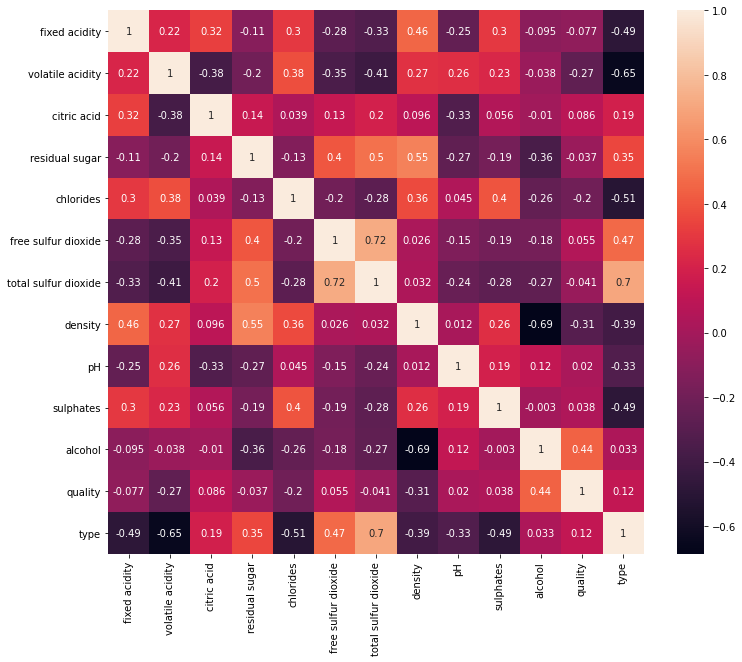

In [94]:
plt.figure(figsize=(12,10))

sns.heatmap(df.corr(),annot=True)

The Countplot below shows us how there are very few instances available for some classes. This right here is <b>Class Imbalance Problem</b>.

Due to Class Imbalance, we might have difficulty while training. Models can overfit on the dominant classes because they don't have enough data from minority classes to train with them. Next, we will see how this problem can be solved.
<br>

<AxesSubplot:xlabel='quality', ylabel='count'>

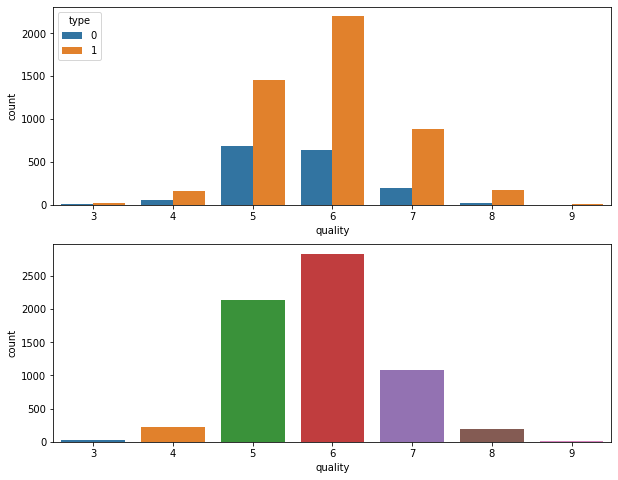

In [95]:
fig,ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

sns.countplot(x='quality',hue='type',data=df,ax=ax[0])
sns.countplot(x='quality',data=df, ax=ax[1])

<br>

## Solving Class Imbalance


<br>

For solving this issue, we will make use of Cost-Sensitive learning. Cost-sensitive learning is a subfield of machine learning that takes the costs of prediction errors (and potentially other costs) into account when training a machine learning model.

We will explore following three approaches for solving Class Imbalance problem one by one.

<b>1. Class Weights</b><br>
<b>2. Oversampling</b><br>
<b>3. Aggregating Classes</b><br>

<br>

### 1. Class Weights

<br>

Using [compute_class_weight()](http://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) method, we get the weights for each class which is assigned to it during training. Then we create a dictionary of classes and weights so it can be passed to algorithms that support custom class weights.

In [96]:
from sklearn.utils.class_weight import compute_class_weight

bal_cw = compute_class_weight(class_weight='balanced',classes=np.unique(df['quality']),y=y_train.values)

cls = list(range(3,10))

bal_dict = {cls[i]:bal_cw[i] for i in range(len(cls))}

print(bal_dict)

{3: 30.931972789115648, 4: 4.3017975402081365, 5: 0.434205500381971, 6: 0.3272400143936668, 7: 0.8603595080416272, 8: 4.811640211640212, 9: 162.39285714285714}


Now that we have weights for each class, we will try to use them in a few models to see how they preform.

Let's first import all the models and methods we'll neeed.

In [97]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [98]:
def plot_confusion_matrix(cm, target_names, title, cmap=None, normalize=True):
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


def fit_pred_print(model, X_train, y_train, X_test, y_test, cf_matrix = False):
    model.fit(X_train, y_train)
    model_pred = model.predict(X_test)
    print(classification_report(y_test, model_pred))
    if cf_matrix == True:
        plot_confusion_matrix(confusion_matrix(y_test, model_pred), ["low", "medium", "high"],
                                   title="Confusion Matrix", normalize=False)

In [99]:
fit_pred_print(LogisticRegression(n_jobs=-1, class_weight=bal_dict), Xt_mms, y_train, Xts_mms, y_test)

              precision    recall  f1-score   support

           3       0.02      0.44      0.04         9
           4       0.09      0.42      0.15        65
           5       0.53      0.45      0.49       642
           6       0.54      0.16      0.25       851
           7       0.31      0.29      0.30       324
           8       0.11      0.45      0.18        58
           9       0.00      0.00      0.00         1

    accuracy                           0.30      1950
   macro avg       0.23      0.32      0.20      1950
weighted avg       0.47      0.30      0.33      1950



In [100]:
fit_pred_print(RidgeClassifier(class_weight=bal_dict), Xt_mms, y_train, Xts_mms, y_test)

              precision    recall  f1-score   support

           3       0.01      0.44      0.03         9
           4       0.08      0.35      0.14        65
           5       0.51      0.46      0.48       642
           6       0.54      0.07      0.12       851
           7       0.28      0.18      0.22       324
           8       0.09      0.28      0.14        58
           9       0.00      1.00      0.01         1

    accuracy                           0.23      1950
   macro avg       0.22      0.40      0.16      1950
weighted avg       0.46      0.23      0.26      1950



In [101]:
fit_pred_print(SVC(class_weight=bal_dict), Xt_mms, y_train, Xts_mms, y_test)

              precision    recall  f1-score   support

           3       0.03      0.22      0.05         9
           4       0.13      0.51      0.21        65
           5       0.55      0.54      0.54       642
           6       0.57      0.26      0.35       851
           7       0.29      0.34      0.31       324
           8       0.14      0.48      0.22        58
           9       0.00      0.00      0.00         1

    accuracy                           0.38      1950
   macro avg       0.24      0.34      0.24      1950
weighted avg       0.49      0.38      0.40      1950



In [102]:
fit_pred_print(DecisionTreeClassifier(class_weight=bal_dict), Xt_mms, y_train, Xts_mms, y_test)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         9
           4       0.18      0.17      0.17        65
           5       0.62      0.64      0.63       642
           6       0.64      0.63      0.64       851
           7       0.53      0.54      0.53       324
           8       0.38      0.36      0.37        58
           9       0.00      0.00      0.00         1

    accuracy                           0.59      1950
   macro avg       0.33      0.33      0.33      1950
weighted avg       0.59      0.59      0.59      1950



These are note good results. They've too low training accuracy and it doesn't seem they'll improve a lot after hyperparameter tuning. Let's move on to trying the next approach.

<br>

### 2. Oversampling

<br>

We will use synthetic oversampling here to increase the number of instances in minority classes and see if performance of algorithms improves. In particular, SMOTE (Synthetic Minority Oversampling TEchnique) algorithm will be used here.

We'll be applying oversampling algorithm on our training data only. If we apply it to the entire dataset, it will create synthetic examples of minority classes (which we already have very few to learn from) and might create instances that are too similar and not indicative or general population/real world.

In [103]:
from imblearn.over_sampling import SMOTE

smote_model = SMOTE(n_jobs=-1, k_neighbors=2)

smote_x, smote_y = smote_model.fit_resample(Xt_mms, y_train)

print("Original Dataset")
print(y_train.value_counts())
print()

print("Oversampled Dataset")
print(smote_y.value_counts())

Original Dataset
6    1985
5    1496
7     755
4     151
8     135
3      21
9       4
Name: quality, dtype: int64

Oversampled Dataset
8    1985
9    1985
3    1985
4    1985
5    1985
6    1985
7    1985
Name: quality, dtype: int64


<br>
As you can see, all the classes have same number of instances as that of the most populated class.

We will train the same four algorithms we tried before with oversampled data to check if there is any improvement in the performance. We won't use balanced class weights as the imbalance has been taken care of by oversampling.

In [104]:
fit_pred_print(LogisticRegression(n_jobs=-1), smote_x, smote_y, Xts_mms, y_test)

              precision    recall  f1-score   support

           3       0.02      0.44      0.03         9
           4       0.09      0.37      0.14        65
           5       0.54      0.41      0.47       642
           6       0.56      0.20      0.30       851
           7       0.29      0.30      0.29       324
           8       0.12      0.48      0.19        58
           9       0.00      0.00      0.00         1

    accuracy                           0.30      1950
   macro avg       0.23      0.32      0.20      1950
weighted avg       0.48      0.30      0.34      1950



In [105]:
fit_pred_print(RidgeClassifier(), smote_x, smote_y, Xts_mms, y_test)

              precision    recall  f1-score   support

           3       0.01      0.44      0.02         9
           4       0.07      0.29      0.12        65
           5       0.51      0.42      0.46       642
           6       0.53      0.08      0.14       851
           7       0.30      0.20      0.24       324
           8       0.08      0.26      0.13        58
           9       0.00      1.00      0.01         1

    accuracy                           0.23      1950
   macro avg       0.22      0.39      0.16      1950
weighted avg       0.45      0.23      0.26      1950



In [106]:
fit_pred_print(SVC(), smote_x, smote_y, Xts_mms, y_test)

              precision    recall  f1-score   support

           3       0.01      0.11      0.02         9
           4       0.12      0.49      0.19        65
           5       0.59      0.53      0.56       642
           6       0.58      0.29      0.39       851
           7       0.31      0.34      0.32       324
           8       0.14      0.57      0.23        58
           9       0.00      0.00      0.00         1

    accuracy                           0.39      1950
   macro avg       0.25      0.33      0.24      1950
weighted avg       0.51      0.39      0.42      1950



In [107]:
fit_pred_print(DecisionTreeClassifier(), smote_x, smote_y, Xts_mms, y_test)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         9
           4       0.19      0.31      0.24        65
           5       0.62      0.60      0.61       642
           6       0.64      0.54      0.59       851
           7       0.46      0.56      0.51       324
           8       0.24      0.38      0.29        58
           9       0.00      0.00      0.00         1

    accuracy                           0.55      1950
   macro avg       0.31      0.34      0.32      1950
weighted avg       0.57      0.55      0.56      1950



<br>

These results show that there is no noticable improvement in results if we use oversampling. It surely is difficult to achieve so when the test data has less than 10 instances for some classes. Before we go ahead with trying to Aggregating Classes, let's see how the models perform without oversampling or class weights.

In [108]:
fit_pred_print(LogisticRegression(n_jobs=-1), Xt_mms, y_train, Xts_mms, y_test)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00        65
           5       0.58      0.61      0.59       642
           6       0.51      0.70      0.59       851
           7       0.45      0.17      0.24       324
           8       0.00      0.00      0.00        58
           9       0.00      0.00      0.00         1

    accuracy                           0.53      1950
   macro avg       0.22      0.21      0.20      1950
weighted avg       0.49      0.53      0.50      1950



In [109]:
fit_pred_print(RidgeClassifier(), Xt_mms, y_train, Xts_mms, y_test)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00        65
           5       0.57      0.62      0.59       642
           6       0.50      0.73      0.60       851
           7       0.56      0.03      0.05       324
           8       0.00      0.00      0.00        58
           9       0.00      0.00      0.00         1

    accuracy                           0.53      1950
   macro avg       0.23      0.20      0.18      1950
weighted avg       0.50      0.53      0.46      1950



In [110]:
fit_pred_print(SVC(), Xt_mms, y_train, Xts_mms, y_test)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00        65
           5       0.61      0.60      0.60       642
           6       0.51      0.75      0.61       851
           7       0.52      0.12      0.20       324
           8       0.00      0.00      0.00        58
           9       0.00      0.00      0.00         1

    accuracy                           0.54      1950
   macro avg       0.23      0.21      0.20      1950
weighted avg       0.51      0.54      0.50      1950



In [111]:
fit_pred_print(DecisionTreeClassifier(), Xt_mms, y_train, Xts_mms, y_test)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         9
           4       0.26      0.18      0.21        65
           5       0.65      0.64      0.64       642
           6       0.62      0.60      0.61       851
           7       0.47      0.54      0.50       324
           8       0.32      0.34      0.33        58
           9       0.00      0.00      0.00         1

    accuracy                           0.58      1950
   macro avg       0.33      0.33      0.33      1950
weighted avg       0.58      0.58      0.58      1950



Now we know that oversampling and class weights actually decreased the accuracy and models couldn't perform well. They didn't actually help with class imbalance problem but made it worse.

Let's see if we can get better performance out of these models after aggregating the classes.

<br>

### 3. Aggregating Classes

Let's have a look at the countplot of the label once again.

<AxesSubplot:xlabel='quality', ylabel='count'>

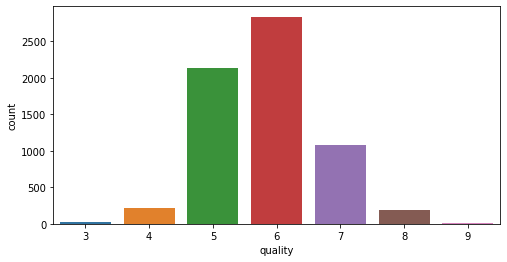

In [112]:
plt.figure(figsize=(8,4))

sns.countplot(x='quality', data=df)

In [113]:
df['quality'].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

Based on the graph and data we have, it seems we can group the actual classes into three groups and pretend they're the new classes. It can look like as follows:

<b>3-4 = LOW will become Class 0</b><br>
<b>5-6 = MEDIUM will become Class 1</b><br>
<b>7-9 = HIGH will become Class 2</b><br>

Let's try this out and use it with algorithms we ran before.

In [114]:
df.quality = df.quality.map({3:0, 4:0, 5:1, 6:1, 7:2, 8:2, 9:2})

df['quality'].value_counts()

1    4974
2    1277
0     246
Name: quality, dtype: int64

In [115]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('quality',axis=1), df['quality'],test_size=0.3,
                                                   stratify=df['quality'])

print("Train test split:")
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print()

print("Y train value counts:")
print(y_train.value_counts())

Train test split:
(4547, 12)
(4547,)
(1950, 12)
(1950,)

Y train value counts:
1    3481
2     894
0     172
Name: quality, dtype: int64


In [116]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer

features = list(X_train.columns)
features.remove('type')

ct_mms = ColumnTransformer([('MinMaxScaler', MinMaxScaler(), features)], remainder='passthrough')
X_train = ct_mms.fit_transform(X_train)
X_test = ct_mms.transform(X_test)

In [117]:
fit_pred_print(LogisticRegression(n_jobs=-1), X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        74
           1       0.80      0.97      0.88      1493
           2       0.69      0.27      0.39       383

    accuracy                           0.79      1950
   macro avg       0.50      0.41      0.42      1950
weighted avg       0.75      0.79      0.75      1950



In [118]:
fit_pred_print(RidgeClassifier(), X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        74
           1       0.79      0.99      0.88      1493
           2       0.78      0.18      0.29       383

    accuracy                           0.79      1950
   macro avg       0.52      0.39      0.39      1950
weighted avg       0.76      0.79      0.73      1950



In [119]:
fit_pred_print(SVC(), X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        74
           1       0.79      0.98      0.88      1493
           2       0.75      0.19      0.31       383

    accuracy                           0.79      1950
   macro avg       0.51      0.39      0.40      1950
weighted avg       0.75      0.79      0.73      1950



In [120]:
fit_pred_print(DecisionTreeClassifier(), X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.22      0.24      0.23        74
           1       0.87      0.85      0.86      1493
           2       0.58      0.61      0.59       383

    accuracy                           0.78      1950
   macro avg       0.56      0.57      0.56      1950
weighted avg       0.79      0.78      0.79      1950



The models have performed far better after aggregating classes. This was expected because now there are less classes and consequently more examples in each class. This gives models enough data from each class to train on.

<br>

## Spot-Check Algorithms

<br>

We'll go ahead with this solution of aggregating classes. Next, we will Spot-Check algorithms for classification and find out which is best performing algorithm. For this, we will use the Spot-Check Framework developed by Jason Brownlee. You can find it by going to [this link](https://machinelearningmastery.com/spot-check-machine-learning-algorithms-in-python/).

Below code cell contains the code from the article with few modifications to give a concise view of the results.

In [121]:
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier


# create a dict of standard models to evaluate {name:object}
def define_models(models=dict()):
	# linear models
	models['logistic'] = LogisticRegression()
	alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	for a in alpha:
		models['ridge-'+str(a)] = RidgeClassifier(alpha=a)
	models['sgd'] = SGDClassifier(max_iter=1000, tol=1e-3)
	models['pa'] = PassiveAggressiveClassifier(max_iter=1000, tol=1e-3)
	# non-linear models
	n_neighbors = range(1, 21)
	for k in n_neighbors:
		models['knn-'+str(k)] = KNeighborsClassifier(n_neighbors=k)
	models['cart'] = DecisionTreeClassifier()
	models['extra'] = ExtraTreeClassifier()
	models['svml'] = SVC(kernel='linear')
	models['svmp'] = SVC(kernel='poly')
	c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	for c in c_values:
		models['svmr'+str(c)] = SVC(C=c)
	models['bayes'] = GaussianNB()
	# ensemble models
	n_trees = 100
	models['ada'] = AdaBoostClassifier(n_estimators=n_trees)
	models['bag'] = BaggingClassifier(n_estimators=n_trees)
	models['rf'] = RandomForestClassifier(n_estimators=n_trees)
	models['et'] = ExtraTreesClassifier(n_estimators=n_trees)
	models['gbm'] = GradientBoostingClassifier(n_estimators=n_trees)
	print('Defined %d models' % len(models))
	return models
 
# create a feature preparation pipeline for a model
def make_pipeline(model):
	steps = list()
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline
 
# evaluate a single model
def evaluate_model(X, y, model, folds, metric):
	# create the pipeline
	pipeline = make_pipeline(model)
	# evaluate model
	scores = cross_val_score(pipeline, X, y, scoring=metric, cv=folds, n_jobs=-1)
	return scores
 
# evaluate a model and try to trap errors and and hide warnings
def robust_evaluate_model(X, y, model, folds, metric):
	scores = None
	scores = evaluate_model(X, y, model, folds, metric)
	return scores
 
# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, folds=5, metric='accuracy'):
	results = dict()
	for name, model in models.items():
		# evaluate the model
		scores = robust_evaluate_model(X, y, model, folds, metric)
		# show process
		if scores is not None:
			# store a result
			results[name] = scores
			mean_score, std_score = mean(scores), std(scores)
		else:
			print('>%s: error' % name)
	return results
 
# print and plot the top n results
def summarize_results(results, maximize=True, top_n=10):
	# check for no results
	if len(results) == 0:
		print('no results')
		return
	# determine how many results to summarize
	n = min(top_n, len(results))
	# create a list of (name, mean(scores)) tuples
	mean_scores = [(k,mean(v)) for k,v in results.items()]
	# sort tuples by mean score
	mean_scores = sorted(mean_scores, key=lambda x: x[1])
	# reverse for descending order (e.g. for accuracy)
	if maximize:
		mean_scores = list(reversed(mean_scores))
	# retrieve the top n for summarization
	names = [x[0] for x in mean_scores[:n]]
	scores = [results[x[0]] for x in mean_scores[:n]]
	# print the top n
	print()
	for i in range(n):
		name = names[i]
		mean_score, std_score = mean(results[name]), std(results[name])
		print('Rank=%d, Name=%s, Score=%.3f (+/- %.3f)' % (i+1, name, mean_score, std_score))
	# boxplot for the top n
	pyplot.boxplot(scores, labels=names)
	_, labels = pyplot.xticks()
	pyplot.setp(labels, rotation=90)
	pyplot.savefig('spotcheck.png')
 
# get model list
models = define_models()

Defined 53 models



Rank=1, Name=et, Score=0.837 (+/- 0.008)
Rank=2, Name=rf, Score=0.835 (+/- 0.005)
Rank=3, Name=bag, Score=0.831 (+/- 0.009)
Rank=4, Name=gbm, Score=0.804 (+/- 0.007)
Rank=5, Name=knn-10, Score=0.790 (+/- 0.009)
Rank=6, Name=knn-4, Score=0.789 (+/- 0.007)
Rank=7, Name=knn-20, Score=0.789 (+/- 0.003)
Rank=8, Name=knn-18, Score=0.788 (+/- 0.003)
Rank=9, Name=knn-8, Score=0.788 (+/- 0.006)
Rank=10, Name=knn-17, Score=0.788 (+/- 0.005)


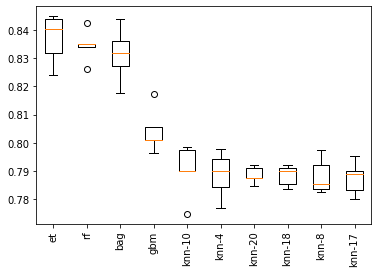

In [122]:
# evaluate models
results = evaluate_models(X_train, y_train, models)
# summarize results
summarize_results(results)

## Hyperparameter Tuning

<br>

From the above results, we see three models stand out. Namely ExtraTreesClassifier, RandomForest, and Bagging. We will run each of them and see which performs best. We will run RandomSearchCV to find suitable parameters for these models. After finding the best one among them, we will use GridSearchCV.

For comparison, we will use a Neural Network as well to see if it performs better.

              precision    recall  f1-score   support

           0       0.50      0.11      0.18        74
           1       0.82      0.96      0.88      1493
           2       0.70      0.33      0.45       383

    accuracy                           0.80      1950
   macro avg       0.67      0.47      0.50      1950
weighted avg       0.78      0.80      0.77      1950



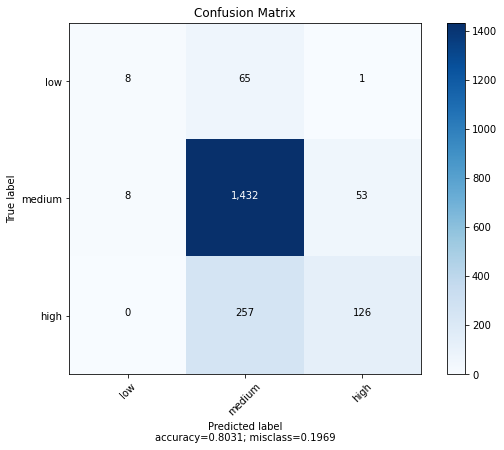

In [123]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

dum_y = pd.get_dummies(y_train)

dum_y = dum_y.reset_index()

dum_y.drop(columns='index', axis=1, inplace=True)

def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(12, input_dim=12, activation='relu'))
	model.add(Dense(12, activation='relu'))
	model.add(Dense(3, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model


estimator = KerasClassifier(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)

nn_pred = fit_pred_print(estimator, X_train, y_train, X_test, y_test, cf_matrix=True)

In [124]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

tree_param = {'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,80,100],
             'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}

randomsrch = RandomizedSearchCV(RandomForestClassifier(), param_distributions=tree_param, cv=5, n_jobs=-1)

results = randomsrch.fit(X_train, y_train)

rftree = RandomForestClassifier(**results.best_params_, n_jobs=-1)

fit_pred_print(rftree, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        74
           1       0.82      0.97      0.89      1493
           2       0.78      0.36      0.49       383

    accuracy                           0.82      1950
   macro avg       0.53      0.45      0.46      1950
weighted avg       0.78      0.82      0.78      1950



In [125]:
tree_param = {'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,80,100],
             'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}

randomsrch = RandomizedSearchCV(ExtraTreesClassifier(), param_distributions=tree_param, cv=5, n_jobs=-1)

results = randomsrch.fit(X_train, y_train)

etree = ExtraTreesClassifier(**results.best_params_, n_jobs=-1)

fit_pred_print(etree, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        74
           1       0.78      0.99      0.87      1493
           2       0.77      0.09      0.17       383

    accuracy                           0.78      1950
   macro avg       0.51      0.36      0.35      1950
weighted avg       0.75      0.78      0.70      1950



In [126]:
bc_params = {"base_estimator__max_depth": range(3,22,2),
"base_estimator__max_features": [None, "auto"],
"base_estimator__min_samples_leaf": range(1,21,2),
"base_estimator__min_samples_split": range(2,19,2),
'bootstrap_features': [False, True],
'max_features': [0.5, 0.7, 1.0],
'max_samples': [0.5, 0.7, 1.0],
'n_estimators': range(2,21,2),
}

bc_gs = RandomizedSearchCV(BaggingClassifier(DecisionTreeClassifier()), bc_params, cv=5, verbose=0, n_jobs=-1)

results = bc_gs.fit(X_train, y_train)

bg = BaggingClassifier(DecisionTreeClassifier())
bg.set_params(**results.best_params_, n_jobs=-1)

fit_pred_print(bg, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.60      0.04      0.08        74
           1       0.84      0.96      0.89      1493
           2       0.74      0.46      0.57       383

    accuracy                           0.83      1950
   macro avg       0.73      0.49      0.51      1950
weighted avg       0.81      0.83      0.80      1950



<br>

From these results, we can say that Bagging Classifier and Neural Network are performing better than others. Bagging might have similar accuracy but it does better in other metrics shown in classification report.


I ran GridSearchCV on Bagging model to see if we can possibly make any improvements. Below are the results I got with the hyperparameters using GridSearchCV.

              precision    recall  f1-score   support

           0       0.75      0.04      0.08        74
           1       0.85      0.97      0.91      1493
           2       0.81      0.54      0.64       383

    accuracy                           0.85      1950
   macro avg       0.80      0.51      0.54      1950
weighted avg       0.84      0.85      0.82      1950



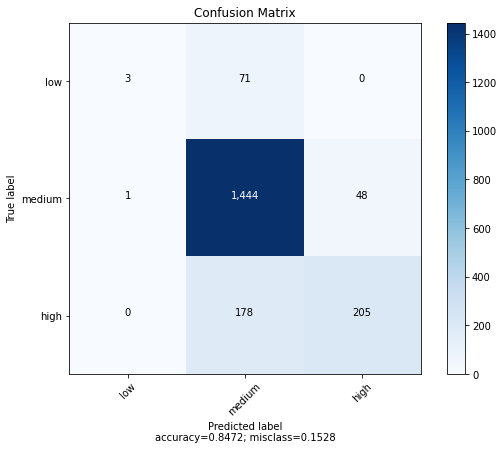

In [127]:
bg = BaggingClassifier(DecisionTreeClassifier(max_depth=20, max_features=None, min_samples_leaf=1,
                                              min_samples_split=5), 
                       bootstrap_features=True, max_features=0.7, max_samples=1.0, n_estimators=20, n_jobs=-1)


bag_pred = fit_pred_print(bg, X_train, y_train, X_test, y_test, cf_matrix=True)

This tuned model works a little better than the previous model but improvement isn't significant. However, it is worth running GridSearchCV because you find global optima instead of a local from RandomSearchCV.

By doing multiple runs of models we have chosen for doing hyperparameter tuning, we realised that RandomForest and ExtraTrees classifiers are not ideal as they're performing poorly with low quality wines. On the other hand, Neural Network and Bagging classifier show better performance with some variation amongst both.

<br>

## Conclusion

- We can now establish based on results that Neural Network and Bagging Classifier work the best for solving our problem. One clearly performs better than the other. However, we can also look at both of them closely.
- Bagging Classifier gives best accuracy amongst all the models we've seen so far. We can say that model is performing in all areas and for all classes well based on the Precision, Recall, and F1 Score parameters. It surely outperforms NN in predicting High quality wines but in some cases loses to it when it comes to Low quality wines.
- Neural Network has less accuracy but it makes good predictions for all the classes. It certainly performs better with Low quality wines, though marginally. Doesn't do as well as Bagging when it comes to High quality wines. After some more tweaking or with right architecture, NN can potentially outperform Bagging Classifier. I haven't gone deep into that part here though.
- Looking at the way classes are aggregated, reader might be tempeted to question if that was the correct way to do it. The approach taken here doesn't resolve the imbalance. But it does help a bit. While thinking of aggregation, we need to remember that it wouldn't logically make sense to put the majority classes in two different groups. That might solve the imbalance but the resulting model would not be practical or true to the real world. The imbalance in the dataset here it high and it's difficult to remove it completely.
- The class imbalance still exists even though we have aggregated 2-3 classes. This shows in the results and can be further worked upon. Possibly through Cost Sensitive ensemble methods such as MetaCost and AdaCost. That goes into the category of future work which I intend to add into this notebook. Hopefully soon. :)